<a href="https://colab.research.google.com/github/kzeng4/Deep_learning/blob/CNN/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: [Kangping Zeng]


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [3]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

170508288/170498071 [==============================] - 3s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [4]:
def to_one_hot(y, num_class=10):
    vec = np.zeros((len(y),num_class))
    for i in range(len(y)):
      vec[i,y[i]] = 1
    return vec
    pass

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [5]:
random_id = np.random.RandomState(seed=44).permutation(50000)
train_id = random_id[0:40000]
val_id = random_id[40000:50000]
x_tr = x_train[train_id,:]
y_tr = y_train_vec[train_id,:]
x_val = x_train[val_id,:]
y_val = y_train_vec[val_id,:]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [6]:
# Build the model
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),padding='valid',activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(4,4),padding='valid',activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(10,activation='Softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [8]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers
model.compile(optimizers.Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [9]:
# Train the model and store model parameters/loss values
history = model.fit(x_tr, y_tr,
                   batch_size=128, epochs=50,
                   validation_data=(x_val, y_val))

Epoch 1/50
313/313 [==============================] - 15s 14ms/step - loss: 5.5263 - accuracy: 0.2554 - val_loss: 2.9037 - val_accuracy: 0.3295
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 2.3128 - accuracy: 0.3737 - val_loss: 2.0758 - val_accuracy: 0.3819
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 1.7693 - accuracy: 0.4385 - val_loss: 1.7387 - val_accuracy: 0.4425
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 1.5239 - accuracy: 0.4895 - val_loss: 1.6046 - val_accuracy: 0.4728
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 1.3516 - accuracy: 0.5385 - val_loss: 1.4949 - val_accuracy: 0.5038
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 1.2341 - accuracy: 0.5778 - val_loss: 1.4063 - val_accuracy: 0.5381
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 1.1231 - accuracy: 0.6143 - val_loss: 1.3700 - val_accuracy: 0.552

## 3. Plot the training and validation loss curve versus epochs. (5 points)

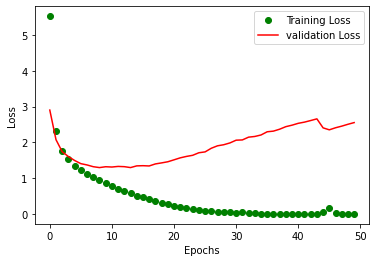

In [10]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(50)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [11]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model.compile(optimizers.Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [12]:
#<Train your model on the entire training set (50K samples)>
history1 = model.fit(x_train, y_train_vec,
                   batch_size=128, epochs=50)

Epoch 1/50
391/391 [==============================] - 5s 11ms/step - loss: 0.4697 - accuracy: 0.9122
Epoch 2/50
391/391 [==============================] - 4s 10ms/step - loss: 0.2890 - accuracy: 0.9323
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 0.1911 - accuracy: 0.9511
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 0.1228 - accuracy: 0.9679
Epoch 5/50
391/391 [==============================] - 4s 11ms/step - loss: 0.0816 - accuracy: 0.9794
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 0.0522 - accuracy: 0.9888
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 0.0362 - accuracy: 0.9932
Epoch 8/50
391/391 [==============================] - 4s 10ms/step - loss: 0.0254 - accuracy: 0.9961
Epoch 9/50
391/391 [==============================] - 4s 10ms/step - loss: 0.0185 - accuracy: 0.9978
Epoch 10/50
391/391 [==============================] - 4s 10ms/step - loss: 0.0150 - accura

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [13]:
# Evaluate your model performance (testing accuracy) on testing data.
test = model.evaluate(x_test,y_test_vec)
#test accuracy is 0.6603

313/313 [==============================] - 2s 6ms/step - loss: 3.4425 - accuracy: 0.6603


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

6.1 Add a Dropout layer before Dense layer


*   In previous model, it shows a significant sign of over fitting.
*   By the dropout technique, we can alleviate this phenomenon and gain better performance.



In [14]:

model1 = models.Sequential()
model1.add(layers.Conv2D(32,(3,3),padding='valid',activation='relu', input_shape=(32,32,3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64,(4,4),padding='valid',activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(10,activation='Softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)             

In [15]:
#compile the model
model1.compile(optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [16]:
#Train the model and store model parameters/loss values
history2 = model1.fit(x_tr, y_tr,
                   batch_size=128, epochs=50,
                   validation_data=(x_val, y_val))

Epoch 1/50
313/313 [==============================] - 6s 15ms/step - loss: 6.7286 - accuracy: 0.1812 - val_loss: 2.0677 - val_accuracy: 0.2415
Epoch 2/50
313/313 [==============================] - 4s 13ms/step - loss: 1.9917 - accuracy: 0.2830 - val_loss: 1.7827 - val_accuracy: 0.3544
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 1.7987 - accuracy: 0.3526 - val_loss: 1.6662 - val_accuracy: 0.4003
Epoch 4/50
313/313 [==============================] - 4s 13ms/step - loss: 1.7220 - accuracy: 0.3800 - val_loss: 1.6181 - val_accuracy: 0.4191
Epoch 5/50
313/313 [==============================] - 4s 13ms/step - loss: 1.6474 - accuracy: 0.4064 - val_loss: 1.5237 - val_accuracy: 0.4558
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 1.6004 - accuracy: 0.4284 - val_loss: 1.5021 - val_accuracy: 0.4693
Epoch 7/50
313/313 [==============================] - 4s 14ms/step - loss: 1.5410 - accuracy: 0.4503 - val_loss: 1.5242 - val_accuracy: 0.4650

In [17]:
#Recompile the model
model1.compile(optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [18]:
#<Train the model on the entire training set 
history1x = model1.fit(x_train, y_train_vec,
                   batch_size=128, epochs=50)

Epoch 1/50
391/391 [==============================] - 6s 12ms/step - loss: 0.8021 - accuracy: 0.7305
Epoch 2/50
391/391 [==============================] - 4s 11ms/step - loss: 0.7721 - accuracy: 0.7378
Epoch 3/50
391/391 [==============================] - 4s 11ms/step - loss: 0.7580 - accuracy: 0.7416
Epoch 4/50
391/391 [==============================] - 4s 11ms/step - loss: 0.7508 - accuracy: 0.7429
Epoch 5/50
391/391 [==============================] - 4s 11ms/step - loss: 0.7284 - accuracy: 0.7516
Epoch 6/50
391/391 [==============================] - 4s 11ms/step - loss: 0.7218 - accuracy: 0.7541
Epoch 7/50
391/391 [==============================] - 4s 11ms/step - loss: 0.7112 - accuracy: 0.7573
Epoch 8/50
391/391 [==============================] - 4s 11ms/step - loss: 0.6971 - accuracy: 0.7625
Epoch 9/50
391/391 [==============================] - 4s 11ms/step - loss: 0.6847 - accuracy: 0.7630
Epoch 10/50
391/391 [==============================] - 4s 11ms/step - loss: 0.6767 - accura

In [19]:
model1.evaluate(x_test,y_test_vec)
#The test accuracy is 0.7232

313/313 [==============================] - 2s 5ms/step - loss: 0.9024 - accuracy: 0.7232


[0.9023768305778503, 0.7232000231742859]

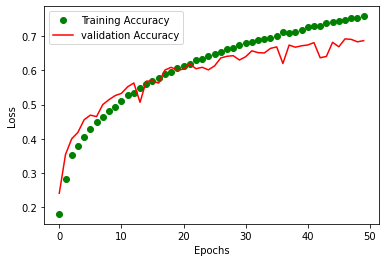

In [24]:
# Plot the accuracy curve
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(50)
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
plt.plot(epochs, train_acc, 'go', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

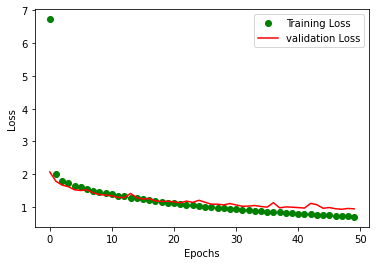

In [25]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline
epochs = range(50)
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
plt.plot(epochs, train_loss, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6.2 Add a dropout layers before Conv layer



In [27]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32,(3,3),padding='valid',activation='relu', input_shape=(32,32,3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64,(4,4),padding='valid',activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(10,activation='Softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2304)             

In [28]:
model2.compile(optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [29]:
history3 = model2.fit(x_tr, y_tr,
                   batch_size=128, epochs=50,
                   validation_data=(x_val, y_val))

Epoch 1/50
313/313 [==============================] - 6s 15ms/step - loss: 12.7191 - accuracy: 0.1154 - val_loss: 2.2994 - val_accuracy: 0.0978
Epoch 2/50
313/313 [==============================] - 4s 13ms/step - loss: 2.2527 - accuracy: 0.1426 - val_loss: 2.1392 - val_accuracy: 0.1715
Epoch 3/50
313/313 [==============================] - 4s 13ms/step - loss: 1.9770 - accuracy: 0.2350 - val_loss: 1.8367 - val_accuracy: 0.3001
Epoch 4/50
313/313 [==============================] - 4s 14ms/step - loss: 1.7856 - accuracy: 0.3198 - val_loss: 1.7023 - val_accuracy: 0.3646
Epoch 5/50
313/313 [==============================] - 4s 13ms/step - loss: 1.6623 - accuracy: 0.3800 - val_loss: 1.6368 - val_accuracy: 0.3940
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 1.5758 - accuracy: 0.4232 - val_loss: 1.5988 - val_accuracy: 0.4009
Epoch 7/50
313/313 [==============================] - 4s 13ms/step - loss: 1.5119 - accuracy: 0.4498 - val_loss: 1.6843 - val_accuracy: 0.376

In [30]:
#Recompile the model
model2.compile(optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [31]:
#<Train the model on the entire training set 
history3x = model2.fit(x_train, y_train_vec,
                   batch_size=128, epochs=50)

Epoch 1/50
391/391 [==============================] - 5s 12ms/step - loss: 0.7425 - accuracy: 0.7503
Epoch 2/50
391/391 [==============================] - 5s 12ms/step - loss: 0.7129 - accuracy: 0.7555
Epoch 3/50
391/391 [==============================] - 5s 12ms/step - loss: 0.7105 - accuracy: 0.7584
Epoch 4/50
391/391 [==============================] - 5s 12ms/step - loss: 0.6957 - accuracy: 0.7619
Epoch 5/50
391/391 [==============================] - 5s 12ms/step - loss: 0.6835 - accuracy: 0.7656
Epoch 6/50
391/391 [==============================] - 5s 12ms/step - loss: 0.6724 - accuracy: 0.7698
Epoch 7/50
391/391 [==============================] - 5s 12ms/step - loss: 0.6591 - accuracy: 0.7752
Epoch 8/50
391/391 [==============================] - 5s 12ms/step - loss: 0.6492 - accuracy: 0.7768
Epoch 9/50
391/391 [==============================] - 4s 11ms/step - loss: 0.6397 - accuracy: 0.7800
Epoch 10/50
391/391 [==============================] - 4s 11ms/step - loss: 0.6306 - accura

In [35]:
model2.evaluate(x_test,y_test_vec)
#the test acc is 0.7133

313/313 [==============================] - 2s 5ms/step - loss: 1.0035 - accuracy: 0.7133


[1.0035377740859985, 0.7132999897003174]

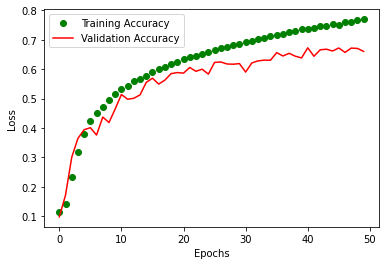

In [33]:
# Plot the accuracy curve
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(50)
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
plt.plot(epochs, train_acc, 'go', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

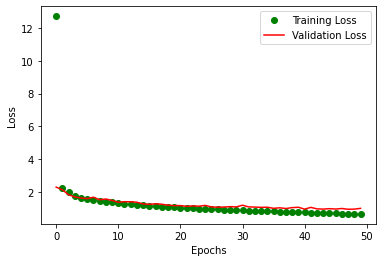

In [34]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline
epochs = range(50)
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
plt.plot(epochs, train_loss, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6.3 Add BN layers


*   In this case, implementation of BN layers can only slightly impove the test accuracy.
*   It performs not so good as drop out layer.



In [36]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32,(3,3),padding='valid', input_shape=(32,32,3)))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(64,(4,4),padding='valid'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(256))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dense(10,activation='Softmax'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 64)      

In [37]:
model3.compile(optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [38]:
history4 = model3.fit(x_tr, y_tr,
                   batch_size=128, epochs=50,
                   validation_data=(x_val, y_val))

Epoch 1/50
313/313 [==============================] - 7s 16ms/step - loss: 1.4843 - accuracy: 0.4767 - val_loss: 1.3147 - val_accuracy: 0.5430
Epoch 2/50
313/313 [==============================] - 5s 16ms/step - loss: 1.1250 - accuracy: 0.6108 - val_loss: 1.1711 - val_accuracy: 0.5926
Epoch 3/50
313/313 [==============================] - 5s 17ms/step - loss: 0.9688 - accuracy: 0.6712 - val_loss: 1.0998 - val_accuracy: 0.6132
Epoch 4/50
313/313 [==============================] - 7s 22ms/step - loss: 0.8656 - accuracy: 0.7095 - val_loss: 1.0268 - val_accuracy: 0.6474
Epoch 5/50
313/313 [==============================] - 5s 16ms/step - loss: 0.7841 - accuracy: 0.7409 - val_loss: 0.9886 - val_accuracy: 0.6579
Epoch 6/50
313/313 [==============================] - 5s 17ms/step - loss: 0.7143 - accuracy: 0.7692 - val_loss: 0.9644 - val_accuracy: 0.6647
Epoch 7/50
313/313 [==============================] - 6s 20ms/step - loss: 0.6546 - accuracy: 0.7907 - val_loss: 1.0007 - val_accuracy: 0.6516

In [39]:
#Recompile the model
model3.compile(optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy',metrics = 'accuracy')

In [40]:
#<Train the model on the entire training set 
history4x = model3.fit(x_train, y_train_vec,
                   batch_size=128, epochs=50)

Epoch 1/50
391/391 [==============================] - 7s 14ms/step - loss: 0.3364 - accuracy: 0.9320
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 0.1962 - accuracy: 0.9496
Epoch 3/50
391/391 [==============================] - 5s 14ms/step - loss: 0.1255 - accuracy: 0.9656
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 0.0846 - accuracy: 0.9772
Epoch 5/50
391/391 [==============================] - 5s 14ms/step - loss: 0.0612 - accuracy: 0.9852
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 0.0447 - accuracy: 0.9909
Epoch 7/50
391/391 [==============================] - 5s 14ms/step - loss: 0.0357 - accuracy: 0.9938
Epoch 8/50
391/391 [==============================] - 5s 14ms/step - loss: 0.0289 - accuracy: 0.9961
Epoch 9/50
391/391 [==============================] - 5s 13ms/step - loss: 0.0242 - accuracy: 0.9971
Epoch 10/50
391/391 [==============================] - 5s 14ms/step - loss: 0.0199 - accura

In [41]:
model3.evaluate(x_test,y_test_vec)
#the test acc is 0.6852

313/313 [==============================] - 2s 5ms/step - loss: 1.9548 - accuracy: 0.6852


[1.9547537565231323, 0.6851999759674072]

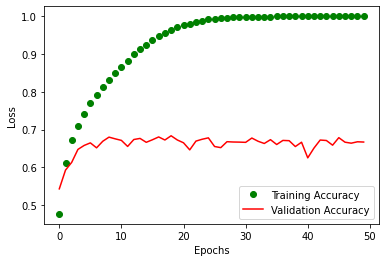

In [42]:
# Plot the accuracy curve
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(50)
train_acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
plt.plot(epochs, train_acc, 'go', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

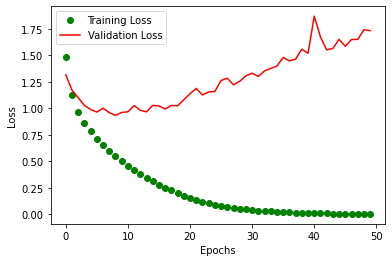

In [43]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline
epochs = range(50)
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']
plt.plot(epochs, train_loss, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()